## Paddy Kaggle Notebook pure Pytorch

In [1]:
import torch
import pandas as pd
import torch.optim as optim
import sklearn
from sklearn.model_selection import train_test_split
sklearn.__version__

# autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import setup_env as su
su.setup_env()

import paddy_funcs_classes as pfc

100%|██████████| 1.02G/1.02G [00:07<00:00, 153MB/s] 



Setup dotfiles...
Running setup.sh...


--2023-03-25 21:01:39--  https://raw.githubusercontent.com/CNUClasses/dotfiles/master/setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021 [text/plain]
Saving to: ‘setup.sh’

     0K                                                       100% 43.9M=0s

2023-03-25 21:01:39 (43.9 MB/s) - ‘setup.sh’ saved [1021/1021]

Cloning into '/root/.cfg'...
rm: cannot remove '/root/.vimrc': No such file or directory
rm: cannot remove '/root/.tmux.conf': No such file or directory
rm: cannot remove '/root/.ctags': No such file or directory


Changing key permissions...
Setup python packages...


## CFG file

In [8]:
CFG=pfc.PROJECT_CFG()

### Get data

In [9]:
df =pd.read_csv(CFG.csv_path)
# df.head()

#EXPERIMENT ON SUBSET OF DATA?
if CFG.subsample_data:
    #stratify dataframe by multiple columns (see Paddy-Multi.ipynb)
    # df, _ = train_test_split(df, test_size=0.5, random_state=0, stratify=df[['label', 'variety']])

    #get a small dataset to train on
    df=df.iloc[:500,:]

    print(df.shape)

# #get a list of files
trn_val_files=pfc.get_fls(CFG.train_path)  
tst_files=pfc.get_fls(CFG.test_path) 
print(f'Len train={len(trn_val_files)}, length test={len(tst_files)}')

Len train=10407, length test=3469


### Stratified Split data

In [10]:
#stratify dataframe by multiple columns (see Paddy-Multi.ipynb)
train, val = train_test_split(df, test_size=CFG.split_fraction, random_state=0, stratify=df[['label', 'variety']])
len(train) + len(val)

10407

### Get list of transforms that the original model used (mean, std)

In [11]:
import timm
cfg=timm.data.resolve_data_config({}, model=CFG.model_name, verbose=True)
cfg

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875}

### Create Datasets

In [12]:
#forward and reverse map labels and varieties
mpr=pfc.mapper(df)

#get transforms
train_transforms, val_transforms=pfc.get_transforms(cfg)

trn_dataset = pfc.MultiTaskDatasetTrain(CFG.train_path,df=train,mpr=mpr,transforms=train_transforms) #use train df
val_dataset = pfc.MultiTaskDatasetTrain(CFG.train_path,df=val,mpr=mpr,transforms=val_transforms)   #use val df
test_dataset= pfc.MultiTaskDatasetTest(CFG.test_path, transforms=val_transforms)            #test set

print(f'Number train images={len(trn_dataset)}, number validation={len(val_dataset)}, and number test images={len(test_dataset)}')

if(not CFG.subsample_data):
    assert(len(trn_dataset)+len(val_dataset)==len(trn_val_files))
    assert(len(test_dataset)==len(tst_files))

Number train images=8325, number validation=2082, and number test images=3469


### Create DataLoaders

In [13]:
from torch.utils.data import DataLoader
trn_dl=DataLoader(trn_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2,drop_last=CFG.drop_last) #drop last to avoid crash
# trn_dl=DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2,drop_last=CFG.drop_last) #drop last to avoid crash

val_dl=DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2,drop_last=CFG.drop_last)

#### Sizes from DataLoader

In [14]:
import matplotlib.pyplot as plt
imgs,lbls,varieties = next(iter(val_dl))
print(f"Feature batch shape: {imgs.size()}")
print(f"Labels batch shape: {lbls.size()}")
print(f"Varieties batch shape: {varieties.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Varieties batch shape: torch.Size([32])


#### Show the images <mark> is this correct?

In [17]:
def show_some_images():
    #look at original image and new one
    from PIL import Image
    import numpy as np
    img1,lbl,variety = val_dataset[0]

    # original image (PIL)
    Image.open(val_dataset.files[0]).show()

    #see returned as a PIL image
    import torchvision.transforms as T
    transform = T.ToPILImage()
    transform(img1).show()

    #show as raw tensor
    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    show(img1)

    mpr=pfc.mapper(df)   
    print(f"Label: {mpr.i_to_label[lbl]}")
    print(f"Variety: {mpr.i_to_variety[variety]}")
    
# show_some_images()

### Try and find a good learning rate, Optuna 

#### Load Optuna

In [34]:
%%time
import optuna

def objective(trial,trn_dl=trn_dl,val_dl=val_dl):
    
    #these are the parameters I want to optimize
    lr = trial.suggest_float("lr", 1e-5, 1e-1)
    
    #get a model
    lrn=pfc.get_Learner(CFG.model_name,min_lr=lr,max_lr=10*lr, num_epochs=1,trn_dl=trn_dl,num_output_classes=CFG.num_classes_in_output_layer,momentum=CFG.momentum)  

    #train the model
    lrn._trn_epoch(trn_dl)
    
    #see how good it is
    acc_labl,_ = pfc.get_accuracy(lrn.m,val_dl, verbose=False)
    
    #return score
    return acc_labl

# object that will optimize the objective
study = optuna.create_study(direction='maximize')

#start optimizing, go for 50 rounds
study.optimize(objective, n_trials=3)

trial = study.best_trial

print('best accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-25 20:32:44,153] A new study created in memory with name: no-name-2928c269-f158-42db-8b21-ae1f57f9c2ae


train:err_rate_labels=0.86,   label_loss=2.76,  err_rate_varieties=0.35 varieties_loss=2.0035


[I 2023-03-25 20:34:19,721] Trial 0 finished with value: 16.098484848484848 and parameters: {'lr': 0.09175289240384003}. Best is trial 0 with value: 16.098484848484848.


train:err_rate_labels=0.88,   label_loss=2.76,  err_rate_varieties=0.36 varieties_loss=2.3341


[I 2023-03-25 20:35:52,694] Trial 1 finished with value: 10.700757575757576 and parameters: {'lr': 0.05140277315811744}. Best is trial 0 with value: 16.098484848484848.


train:err_rate_labels=0.69,   label_loss=1.99,  err_rate_varieties=0.32 varieties_loss=1.14


[I 2023-03-25 20:37:25,971] Trial 2 finished with value: 43.75 and parameters: {'lr': 0.0030471567645366723}. Best is trial 2 with value: 43.75.


best accuracy: 43.75
Best hyperparameters: {'lr': 0.0030471567645366723}
CPU times: user 3min 1s, sys: 1min 31s, total: 4min 33s
Wall time: 4min 41s


### Load and Train Model

In [18]:
%%time
lrn=pfc.get_Learner(model_name=CFG.model_name,min_lr=CFG.LEARNING_RATE_MIN,max_lr=CFG.LEARNING_RATE_MAX, num_epochs=CFG.N_EPOCHS,trn_dl=trn_dl,num_output_classes=CFG.num_classes_in_output_layer,momentum=CFG.momentum)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


CPU times: user 1.74 s, sys: 1.05 s, total: 2.79 s
Wall time: 3.43 s


In [19]:
%%time
#train the model
lrn.learn(trn_dl,val_dl,num_epochs=CFG.N_EPOCHS)

NameError: name 'pred_lbls' is not defined

### Lets plot the cyclic learning rate

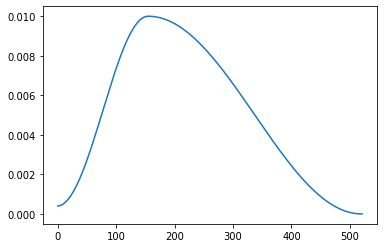

In [24]:
import matplotlib.pyplot as plt
plt.plot(lrn.lrs)

## Predict on the val set 

In [25]:
pfc.get_accuracy(lrn.m,val_dl)  

Accuracy: Label prediction=82.05%,  Variety prediction=90.67


(82.05492424242425, 90.67234848484848)

## Generate submission

In [ ]:
#generate sorted list of files
test_dataset=MultiTaskDatasetTest(CFG.test_path, transforms=val_transforms) 
test_dataset.files.sort()

#generate a non_shuffle dataloader
tst_dl=DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=1,drop_last=False)

#where is the model
device = next(m1.parameters()).device.type

#get model predictions
labels=[]
for imgs in tst_dl:
    imgs = imgs.to(device)

    # forward + backward + optimize
    pred_lbls,_ = lrn.m(imgs)
    
    #get the max index
    pred_lbls=torch.argmax(pred_lbls,dim=1).tolist()
    labels=labels+pred_lbls   

#convert indexes to labels
new_labels=[mpr.i_to_label[i] for i in labels]
# get a list of files
files=[fle.split('/')[-1] for fle in test_dataset.files]   

with open('./submission.csv','w') as fle:
    fle.write('image_id,label')
    for i in range(len(files)):
        fle.write('\n'+files[i]+','+new_labels[i])

## Zip And Upload to Kaggle


In [ ]:
!zip ./submission.zip ./submission.csv
!kaggle competitions submit -c paddy-disease-classification -f submission.zip -m "Message"

## Experiment

In [ ]:
#where is this model located?
# tmodel1=timm.create_model(model_name, pretrained=True, num_classes=13,global_pool='catavgmax')  #going to replace the 13
# next(tmodel1.parameters()).device.type

#     def _one_epoch(self,dl,training):
#         running_loss_labels = 0.0
#         running_loss_varieties = 0.0
#         running_err_rate_labels =0.0
#         running_err_rate_varieties =0.0
#         is_trn=self.m.training
        
#         # for i, data in (enumerate(tqdm(dl), 0)):
#         print()
#         for i, data in (enumerate(dl)):

#             # get the inputs, labels is tuple(label, variety)
#             imgs,lbls,varietys = data[0].to(self.device),data[1].to(self.device),data[2].to(self.device)
           
#             if training:
#                 # zero the parameter gradients
#                 self.optimizer.zero_grad()
 
#             # forward + backward + optimize
#             pred_lbls,pred_varieties = self.m(imgs)
             
#             loss_labels , loss_varieties = self.criterion(pred_lbls,pred_varieties, lbls,varietys)
            
#             if training:
#                 #see https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
#                 loss_labels.backward(retain_graph=True)
#                 loss_varieties.backward()

#             running_loss_labels+=loss_labels.item()
#             running_loss_varieties+=loss_varieties.item()
#             running_err_rate_labels+=error_rate(pred_lbls,lbls)
#             running_err_rate_varieties+=error_rate(pred_varieties,varietys)
 
#             #adjust weights
#             self.optimizer.step()

#             if (i%CFG.print_freq==0):
#                 state='train' if is_trn else 'valid' 
#                 print(f'{state}:err_rate_labels={(running_err_rate_labels/(i)):.2f},   label_loss={(running_loss_labels):.2f},   err_rate_varieties={(running_err_rate_varieties/(i)):.2f}   varieties_loss={(running_loss_varieties):.2f},    ', end='\r', flush=True)
#                 running_loss_labels = 0.0
#                 running_loss_varieties = 0.0
        

In [ ]:
# m1.train()
# m1.eval()
# print(f'{m1.training}, {m1.m.training}, {m1.m.fc.training}')

#check shapes
# (next(iter(trn_dl))[-2:])

# m1.eval()
# m1(trn_dataset[0][0].unsqueeze(0))

 #calls forward
# m1(next(iter(trn_dl))[0]) 
# m1(val_dataset[0].unsqueeze(0))

# m1(torch.randn(1,3,224,224))



# criterion=DiseaseAndTypeClassifierLoss()
# optimizer = optim.SGD(m1.parameters(), lr=0.001, momentum=0.9)
# num_epochs=3
# numb_batches_between_prints=1

        
        
# for epoch in range(num_epochs):  # loop over the dataset multiple times

#     running_loss_labels = 0.0
#     running_loss_varieties = 0.0
#     num_batches=len(trn_dl)/trn_dl.batch_size
#     m1.train()
#     for i, data in (enumerate(tqdm(trn_dl), 0)):

#         # get the inputs, labels is tuple(label, variety)
#         imgs,lbls,varietys = data[0].to(device),data[1].to(device),data[2].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         pred_lbls,pred_varieties = m1(imgs)
        
#         #loss
#         # loss = criterion(pred_lbls,pred_varieties, lbls,varietys)
#         # loss.backward()
#         loss_labels , loss_varieties = criterion(pred_lbls,pred_varieties, lbls,varietys)
#         loss_labels.backward()
#         loss_varieties.backward()
        
#         running_loss_labels+=loss_labels.item()
#         running_loss_varieties+=loss_varieties.item()
        
#         #adjust weights
#         optimizer.step()
        
#         if i%numb_batches_between_prints==0:
#             if(
#             print(f'label_loss={running_loss_labels/(numb_batches_between_prints*batch_size):.2f}, \
#                   varieties_loss={running_loss_varieties/(numb_batches_between_prints*batch_size):.2f}', end='\r', flush=True)
#             running_loss_labels = 0.0
#             running_loss_varieties = 0.0
    
#     # m1.eval()
#     # num_batches=len(val_dl)/batch_size
#     # for i, data in (enumerate(tqdm(val_dl), 0)): 

        
        
 

# # print('Finished Training')

In [ ]:
# a=np.nan
# a

# import math
# assert (math.isnan(a))

In [ ]:
# m1=timm.create_model('resnet26d', pretrained=True, num_classes=10,global_pool='catavgmax')  #going to replace the 13
# m2=timm.create_model(CFG.model_name, pretrained=True, num_classes=10,global_pool='catavgmax')  #going to replace the 13

# def get_fc(m):
#     #when iterator is exhausted, item will hold last layer
#     for item in m.children():
#         pass
#     print(type(item))
#     if(isinstance(item,torch.nn.modules.linear.Linear)):
#         print('Its linear')
#     else:
#         item= get_fc(item)   
#     return item

# fcl=get_fc(m1)
# m2.head.fc=nn.Sequential(
#             nn.Linear(in_features=m1.get_classifier().in_features,out_features=512, bias=False),
#             nn.ReLU())



# m11=DiseaseAndTypeClassifier(m1)
# m22=DiseaseAndTypeClassifier(m2)

# #convnext has no m1.fc, get its head this way
# tmodel.head.fc